# framework RACC

Ce framework a pour objectif de mettre en place la méthode RACC sur des données MO (SSMIS) et IR (Meteosat)
Les changements à faire dans le code sont marqués par le mot clé TODO

## imports

In [22]:
# reloading 
%load_ext autoreload
%autoreload 2

# importing librairies
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date, timedelta
from scipy.stats import pearsonr, spearmanr

import json
import glob
import sys
import warnings
import os

# importing modules from RACC directory
from classification import classification
import ground_truth as gt

# importing modules from Images
sys.path.insert(0, r'../Images')
from Image import Image
from File import File
from Geotiff_Format import Geotiff_Format

# importing meteosat API modules
sys.path.insert(0, r'API_meteosat')
from eds_get_nearest import search_nearest,download_dataset
sys.path.insert(0, r'API_nsidc')
from nsidc_download import cmr_search,cmr_download

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Initialisation des variables principales

On définit les chemins d'accès principaux afin d'obtenir les variables utiles dans tout le code

In [23]:
def get_index(index_path):
    with open(index_path, "r", encoding="utf-8") as json_dict:
        index = json.load(json_dict)
    return index
    
def save_index(index,index_path):
    with open(index_path, 'w', encoding="utf-8") as json_dict:
        json.dump(index, json_dict, indent=4, default=str)
        
def make_directory(path):
    if not os.path.exists(path):
        os.makedirs(path)
    return path

In [62]:
# TODO : remplir le chemin d'accès au dossier principal où tous les fichiers seront générés
main_dir = make_directory(r"../../data/RACC/dec_2020")

# TODO : remplir le chemin d'accès au fichier json contenant les dates et leurs différents attributs
index_path = main_dir + r"/acq_dates.json"

# TODO : remplir le chemin d'accès au fichier json contenant les paramètres de la projection comme la résolution et l'emprise
projection_path = r"../../data/param_proj/param_guy.json"

# TODO : compléter les dates visées dans le format suivant
target_dates = [
    "2020-12-01T20:00:00.000000+0000",
    "2020-12-08T16:00:00.000000+0000",
    "2020-12-12T06:00:00.000000+0000",
    "2020-12-12T12:00:00.000000+0000",
    "2020-12-18T01:00:00.000000+0000",
    "2020-12-20T12:00:00.000000+0000",
    "2020-12-24T12:00:00.000000+0000",
    "2020-12-27T02:00:00.000000+0000",
    "2020-12-29T12:00:00.000000+0000",
]


projection = json.load(open(projection_path, "r", encoding="utf-8"))
format = "%Y-%m-%dT%H:%M:%S.%f%z"

index = {d.split(" ")[0]:{"target":d} for d in target_dates}
save_index(index,index_path)   # peut supprimer un fichier courant

## Extraction des images SSMIS 

In [113]:
def download_Meteosat_images(   index_path,
                                download_dir,
                                freq="91*",
                                format="%Y-%m-%dT%H:%M:%S.%f%z",
                                quiet=False,
                                passage="*",
                                capteur="*",
                                reso="3.125km",
                                grid="T"):
    index = get_index(index_path)
    for d in index.keys():
        print(f"_____\nrecherche pour la date {d}")
        if f"SSMI_{freq}" in index[d].keys():
            print(f"une image a déjà été enregistrée pour la fréquence {freq} à la date {d}")
            break
        tg_date = datetime.strptime(d,format)
        tg_year = tg_date.year
        tg_day = (tg_date.date() - date(tg_year,1,1)).days + 1
        delta = timedelta(days=3)
        url_list = cmr_search(  short_name='NSIDC-0630', 
                                version='1', 
                                time_start=datetime.strftime(tg_date-delta,"%Y-%m-%dT%H:%M:%S")+"Z",
                                time_end=datetime.strftime(tg_date+delta,"%Y-%m-%dT%H:%M:%S")+"Z",
                                bounding_box='-61.27,-2.38,-47.66,10.86',
                                filename_filter=f'NSIDC-0630-EASE2_{grid}{reso}-{capteur}_SSMIS-{tg_year}{tg_day}-{freq}-{passage}*', 
                                quiet=quiet)
        print(f'NSIDC-0630-EASE2_T3.125km-{capteur}_SSMIS-{tg_year}{tg_day}-{freq}-{passage}*')
        for url in url_list:
            if url[-2:] == "nc":
                filename = download_dir+ "/" + url.split('/')[-1]
                if os.path.exists(filename):
                    print(f"le fichier {filename} a déjà été téléchargé")
                else:
                    cmr_download([url,url+".xml"], download_dir, quiet=quiet)
                file = File(filename)
                img = file.project(projection,"TB")
                try : # on compte les occurences de 0 pour déterminer si le fichier est corrompu
                    unique, counts = np.unique(img.array, return_counts=True)
                    zero_rate = dict(zip(unique, counts))[0]/(img.array.shape[0]*img.array.shape[1])
                except KeyError: # aucune occurence de 0
                    zero_rate = 0
                start_date, end_date = file.getAcqDates()
                print(f"image analysée : zero_rate={zero_rate}, start_date: {start_date}, end_date: {end_date}")
                if (zero_rate < 0.1) and (start_date < tg_date < end_date):
                    print(f"image trouvée à la date {d}")
                    img.show()
                    index[d][f"SSMI_{freq}_src"] = filename
                    index[d]["start_date"] = datetime.strftime(start_date,format)
                    index[d]["end_date"] = datetime.strftime(end_date,format)
                    save_index(index,index_path)
                    break

def prepare_SSMI_images(index_path, out_dir, key, attribute, projection, new_key="SSMI_91*_tif"):
    """
    prépare les images SEVIRI en réalisant leur extraction et leur projection par date
    """
    index = get_index(index_path)
    for d in index.keys():
        string_d = d[:10]
        try:
            file = File(index[d][key])
            key_for_path = key.replace("*","pol")
            out_fn = out_dir + rf"/{attribute}_{key_for_path}_{string_d}.tiff"
            file.project(projection,attribute,out_path=out_fn)
            index[d][new_key] = out_fn
            save_index(index,index_path)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")

In [ ]:
download_dir = make_directory(r"../../data/SSMI/download_dec_2020")
SSMIS_dir = make_directory(main_dir + r"/SSMIS")

freq = "91*" ; 
download_Meteosat_images(index_path,download_dir,freq=freq,format=format,quiet=True)
prepare_SSMI_images(index_path, SSMIS_dir, f"SSMI_{freq}_src", "TB", projection, new_key="SSMI_91*_tif")


## Extraction des images SEVIRI

In [114]:
def download_SEVIRI_images( index_path,
                            unzipped_dir,
                            download_dir,
                            path_API_keys,
                            nb_files_per_period=12,
                            key_SSMI="SSMI_91",
                            format="%Y-%m-%dT%H:%M:%S.%f%z"):
    index = get_index(index_path)
    prod_list = []
    for d in index.keys():
        index[d]["Meteosat_imgs"] = {}
        SSMIS_file = File(index[d][key_SSMI])
        start_acq_date,end_acq_date = SSMIS_file.getAcqDates()
        seconds = (end_acq_date - start_acq_date).total_seconds() / nb_files_per_period
        delta = timedelta(seconds=seconds)
        researched_dates = [start_acq_date + i*delta for i in range(nb_files_per_period)]
        for i in range(len(researched_dates)):
            res_d = researched_dates[i]
            prod, Meteosat_date = search_nearest(res_d)
            filename = fr"{unzipped_dir}/{prod}.nat"
            index[d]["Meteosat_imgs"][i] = {    "file": filename,
                                                "date": datetime.strftime(Meteosat_date,format)}
            if os.path.exists(filename):
                print(f"le fichier {filename} a déjà été téléchargé")
            else:
                prod_list.append(prod)
                
    #print(f"téléchargement de {len(prod_list)} images")
    #download_dataset(prod_list,download_dir,unzipped_dir,path_API_keys)
    save_index(index,index_path)
    

def prepare_SEVIRI_images(index_path, out_dir, attribute, projection):
    """
    prépare les images SEVIRI en réalisant leur extraction, leur projection et leur agrégation

    Args : 
        index_path (string) : chemin d'accès au fichier json contenant les informations sur les fichiers images
        out_dir (string) : chemin vers le dossier où enregistrer les images
        attribute (string) : attribut à extraire
        projection (dict) : dictionnaire contenant les paramètres de projection, notamment l'emprise 

    "Meteosat_imgs": {
            "0": {
                "file": "../../data/SEVIRI/dec_2020/unzipped/MSG4-SEVI-MSG15-0100-NA-20201201171243.037000000Z-NA.nat",
                "date": "2020-12-01T17:12:43.000000+0000"
            },
    """
    index = get_index(index_path)
    for d in index.keys():
        images_dict = index[d]["Meteosat_imgs"]
        arrays_SEVIRI_d = []
        for img_idx in images_dict.keys():
            try:
                SEVIRI_file = File(images_dict[img_idx]["file"])
                img_proj = SEVIRI_file.project(projection,attribute)
                arrays_SEVIRI_d.append(img_proj.array)
            except FileNotFoundError :
                print(f"le fichier {SEVIRI_file.path} n'a pas été trouvé")
                pass
        img_proj_agreg = Image(np.mean(np.array(arrays_SEVIRI_d),axis=0),img_proj.lons,img_proj.lats)
        filename = out_dir + rf"/TB_SEVIRI_{attribute}_{d[:10]}.tiff"
        img_proj_agreg.save(projection,filename)
        index[d][f"SEVIRI_{attribute}_tif"] = filename
    save_index(index,index_path)
        

In [ ]:
SEVIRI_dir_zipped = r"../../data/SEVIRI/dec_2020/zipped"
SEVIRI_dir_unzipped = r"../../data/SEVIRI/dec_2020/unzipped"
SEVIRI_dir = make_directory(main_dir + r"/SEVIRI")

path_keys = r"../../data/keys/eds.key"

#download_SEVIRI_images(index_path, SEVIRI_dir_unzipped, SEVIRI_dir_zipped, path_keys, nb_files_per_period=12, key_SSMI="SSMI_91*_src", format=format)
prepare_SEVIRI_images(index_path, SEVIRI_dir, "IR_108", projection)

## Calcul du facteur de pluie

In [29]:
def compute_rain_rate(index_path,out_dir,projection,key1="SSMI_37V_proj",key2="SSMI_19V_proj"):
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            img_TB37v = File(index[d][key1]).getImage(1)
            img_TB19v = File(index[d][key2]).getImage(1)
            TB37v = np.where(img_TB37v.array==0,np.NaN,img_TB37v.array)
            TB19v = np.where(img_TB19v.array==0,np.NaN,img_TB19v.array)
            R = np.exp(-17.76849 - 0.09612*TB37v + 0.15678*TB19v) -1 
            img_rain_rate = Image(R,img_TB37v.lons,img_TB37v.lats)
            filename = out_dir + rf"/rain_rate_{d[:10]}.tiff"
            img_rain_rate.save(projection,filename)
            index[d]["rain_rate"] = filename
            save_index(index,index_path)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé")

In [30]:
out_dir = make_directory(main_dir + r"/rain_rate")

compute_rain_rate(index_path,out_dir,projection)

le fichier correspondant à la date 2020-12-01T20:00:00.000000+0000 n'a pas été trouvé


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
 

## Agrégation des données

In [33]:
def agregation_geotiff(index_path,out_dir,key,mode="mean",compute_var=False):
    arrays = []
    index = get_index(index_path)
    for d in index.keys(): # récupération des images
        try:
            file = File(index[d][key])
            if file.format != Geotiff_Format:
                print("le fichier doit être en format Geotiff")
                raise
            img = file.getImage(1)
            arrays.append(img.array)
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    lons,lats = img.lons, img.lats
    if mode == "mean":
        output = np.nanmean(np.array(arrays),axis=0)
    else:
        output = np.sum(np.array(arrays),axis=0)
    img_output = Image(output, lons, lats)
    img_output.save(projection,out_dir + rf"/{key}_agreg.tiff")
    if compute_var:
        img_output_var = img_output.computeVar()
        img_output_var.save(projection,out_dir + rf"/{key}_agreg_var.tiff")


In [35]:
agr_dir = make_directory(main_dir + r"/agregation")
key = "IR_087" ; var = True
#key = "SSMIS_91V" ; var = False
key = "rain_rate" ; var = False
agregation_geotiff(index_path,agr_dir,key,compute_var=var)

le fichier correspondant à la date 2020-12-01T20:00:00.000000+0000 n'a pas été trouvé pour la clé rain_rate


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


## Classification

Segmentation des images en entrée à partir de la méthode des K-means

c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)


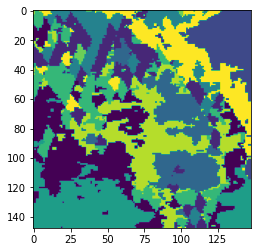

In [54]:
seg_dir = main_dir + r"/segmentation"
array_pred,centers = classification(agr_dir,seg_dir,projection,N=10,epsilon=0.001,T=100)

## Corrélation

In [143]:
def correl_rr_gt(   index_path,
                    path_GT,
                    path_metadata_GT,
                    projection,
                    attribute=1,
                    key="rain_rate",
                    indice_corr="Pearson",
                    savefig=False,
                    start_date_key="start_date",
                    end_date_key="end_date",
                    format="%Y-%m-%dT%H:%M:%S.%f%z"
                    ):
    """
    Calcule la corrélation de Pearson entre les mesures prises sur le terrain et les valeurs d'une image satellite
    """
    # récupération des fichiers
    gt_dict = gt.csv2dict(path_GT)[0]
    metadata_gt = gt.get_metadata(path_metadata_GT)
    index = get_index(index_path)
    # initialisation des listes contenant les données dont on va calculer la corrélation
    estim_rain, true_rain, locations = [], [], []
    for d in index.keys(): 
        try:
            file = File(index[d][key])
            img = file.project(projection,attribute)
            start_date = datetime.strptime(index[d][start_date_key],format)
            end_date = datetime.strptime(index[d][end_date_key],format)
            extr_gt_dict = gt.extract(gt_dict,start_date,end_date)
            agr_gt_dict = gt.agreg(extr_gt_dict,method="mean")
            agr_gt = np.array([agr_gt_dict[d] for d in agr_gt_dict.keys()])
            for k in metadata_gt.keys():
                lat, lon = float(metadata_gt[k]["lat"]),float(metadata_gt[k]["lon"])
                lats, lons = img.lats.T[0], img.lons[0]
                idx_lat,idx_lon = (np.abs(lats - lat)).argmin(), (np.abs(lons - lon)).argmin()
                estimated_rain = img.array[idx_lat][idx_lon]
                if not np.isnan(estimated_rain):
                    true_rain.append(agr_gt[0][k-1])
                    estim_rain.append(estimated_rain)
                    locations.append(metadata_gt[k]["Nom"])
        except KeyError:
            print(f"le fichier correspondant à la date {d} n'a pas été trouvé pour la clé {key}")
    
    if indice_corr == "Pearson":
        corr, _ = pearsonr(estim_rain, true_rain)
    elif indice_corr == "Spearman":
        corr, _ = spearmanr(estim_rain, true_rain)

    
    color_list = ["red","green","blue","orange","yellow","pink","black","purple","beige","brown","gray","cyan"]
    colors = [color_list[np.where(np.unique(locations)==loc)[0][0]] for loc in locations]
    plt.scatter(true_rain,estim_rain,c=colors,s=60, alpha=0.8)
    plt.title(f"indice de corrélation de {indice_corr}: {round(corr,3)}")
    plt.xlabel("pluviommétrie moyenne sur la période d'acquisition en mm")
    plt.ylabel("température de brillance mesurée par SSMIS à 91GHz")
    for i in range(len(np.unique(locations))):
        print(color_list[i],"\t",np.unique(locations)[i])
    if savefig:
        plt.savefig(savefig, dpi=500)

720 lignes ont été écartées, il s'agit probablement de lignes vides


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
 

red 	 CAYENNE—MATOURY
green 	 ILE ROYALE
blue 	 KOUROU CSG
orange 	 KOUROU PLAGE
yellow 	 MARIPASOULA
pink 	 SAINT GEORGES
black 	 SAINT LAURENT


c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
c:\Users\Baptiste\anaconda3\envs\sat_env\lib\site-packages\pyproj\crs\crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
 

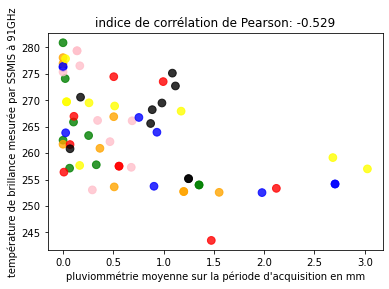

In [144]:
gt_fn = r"../../data/pluie_sol/gg_12-20_1h.csv"
mtd_fn = r"../../data/pluie_sol/gauges_guyane_metadata.csv"

proj_st_geo = r"../../data/param_proj/param_St_Georges.json"
proj_st_lau = r"../../data/param_proj/param_St_Laurent.json"
proj_test = r"../../data/param_proj/test.json"
projection_path = projection_path
param_proj = json.load(open(proj_st_geo, "r", encoding="utf-8"))

savefig = r"../../rapports/images/correlation_TBMOtrop_VT_guy.png"

correl_rr_gt(   index_path,
                gt_fn,
                mtd_fn,
                projection,
                key="SEVIRI_IR_108_tif",
                indice_corr="Pearson",
                attribute=1,
                format="%Y-%m-%dT%H:%M:%S.%f%z",
                savefig=False
                )


In [142]:
index = get_index(index_path)
for d in index.keys(): 
    file = File(index[d]["SSMI_91*_src"])
    str_date,end_date = file.getAcqDates()
    index[d]["start_date"] = datetime.strftime(str_date,format)
    index[d]["end_date"] = datetime.strftime(end_date,format)
save_index(index,index_path)